In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1440
[0.16312509029104827, 0.09636490446440792, 0.03636643773183382, 0.21849298240279427, 0.03651675631669997, 0.019132423710002903, 0.05933243108388687, 0.12247264926103713, 0.6385500001324462, 0.2022302569658592, 0.07471903553293849, 0.16814292142663018, 0.0230523225129767, 0.1609042880961581, 0.2688387764755287, 0.05549755459546917, 0.012694034520736917, 0.09389877662294215, 0.024808470564410257, 0.012916016567435117, 0.537538199511473, 0.10166459547430746, 0.017003778368234634, 0.1895631651814792, 0.011007644292289143, 0.1908368021249771, 0.16246922314167023, 0.09223736189469771, 0.08370963329421344, 0.5588908545309716, 0.03431704460795354, 0.045772770042914156, 0.15501195511789118, 0.026778635366288318, 0.02533061849344048, 0.044663360767730004, 0.05472224588958281, 0.028879488831018898, 0.1309257580510967, 0.11610612932071074, 0.7052331632631441, 0.42965823402192654, 0.09028542237526906, 0.08645685263723765, 0.6922198305107939, 0.5510788138832429, 0.014685248829668424, 0.02854885

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


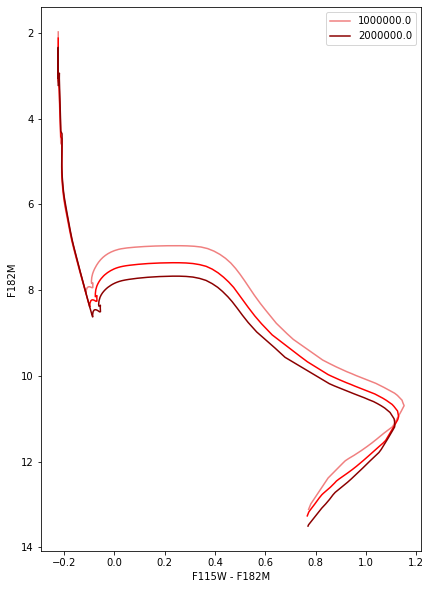

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isoch

Desired mass 0.027940800992853697 is outside the range of the isochrone.
Desired mass 0.027940800992853697 is outside the range of the isochrone.
Desired mass 0.08540540937396021 is outside the range of the isochrone.
Desired mass 0.08540540937396021 is outside the range of the isochrone.
Desired mass 0.03627312957374801 is outside the range of the isochrone.
Desired mass 0.03627312957374801 is outside the range of the isochrone.
Desired mass 0.02966536946799412 is outside the range of the isochrone.
Desired mass 0.02966536946799412 is outside the range of the isochrone.
Desired mass 0.028190304255121115 is outside the range of the isochrone.
Desired mass 0.028190304255121115 is outside the range of the isochrone.
Desired mass 0.05093152164905774 is outside the range of the isochrone.
Desired mass 0.05093152164905774 is outside the range of the isochrone.
Desired mass 0.030234691862541095 is outside the range of the isochrone.
Desired mass 0.030234691862541095 is outside the range of t

Desired mass 0.054994031065844814 is outside the range of the isochrone.
Desired mass 0.054994031065844814 is outside the range of the isochrone.
Desired mass 0.04044839321414944 is outside the range of the isochrone.
Desired mass 0.04044839321414944 is outside the range of the isochrone.
Desired mass 0.10449443997659066 is outside the range of the isochrone.
Desired mass 0.08152095635521138 is outside the range of the isochrone.
Desired mass 0.08152095635521138 is outside the range of the isochrone.
Desired mass 0.09390489245804319 is outside the range of the isochrone.
Desired mass 0.09390489245804319 is outside the range of the isochrone.
Desired mass 0.07224288306638207 is outside the range of the isochrone.
Desired mass 0.07224288306638207 is outside the range of the isochrone.
Desired mass 0.05705773085355759 is outside the range of the isochrone.
Desired mass 0.05705773085355759 is outside the range of the isochrone.
Desired mass 0.028965066193342718 is outside the range of the 

Desired mass 0.10024156851122062 is outside the range of the isochrone.
Desired mass 0.10024156851122062 is outside the range of the isochrone.
Desired mass 0.10477128472621576 is outside the range of the isochrone.
Desired mass 0.024277482168087734 is outside the range of the isochrone.
Desired mass 0.024277482168087734 is outside the range of the isochrone.
Desired mass 0.06886850129428883 is outside the range of the isochrone.
Desired mass 0.06886850129428883 is outside the range of the isochrone.
Desired mass 0.04873664380881346 is outside the range of the isochrone.
Desired mass 0.04873664380881346 is outside the range of the isochrone.
Desired mass 0.06165178602454812 is outside the range of the isochrone.
Desired mass 0.06165178602454812 is outside the range of the isochrone.
Desired mass 0.03082748983403767 is outside the range of the isochrone.
Desired mass 0.03082748983403767 is outside the range of the isochrone.
Desired mass 0.053439728915691376 is outside the range of the 

Desired mass 0.07576969188741094 is outside the range of the isochrone.
Desired mass 0.07576969188741094 is outside the range of the isochrone.
Desired mass 0.05267405758962478 is outside the range of the isochrone.
Desired mass 0.05267405758962478 is outside the range of the isochrone.
Desired mass 0.0466520362963301 is outside the range of the isochrone.
Desired mass 0.0466520362963301 is outside the range of the isochrone.
Desired mass 0.08147184952728756 is outside the range of the isochrone.
Desired mass 0.08147184952728756 is outside the range of the isochrone.
Desired mass 0.022921036788939725 is outside the range of the isochrone.
Desired mass 0.022921036788939725 is outside the range of the isochrone.
Desired mass 0.04525111574527417 is outside the range of the isochrone.
Desired mass 0.04525111574527417 is outside the range of the isochrone.
Desired mass 0.057441554963588715 is outside the range of the isochrone.
Desired mass 0.057441554963588715 is outside the range of the i

Desired mass 0.05451349491252632 is outside the range of the isochrone.
Desired mass 0.05451349491252632 is outside the range of the isochrone.
Desired mass 0.07007405990774677 is outside the range of the isochrone.
Desired mass 0.07007405990774677 is outside the range of the isochrone.
Desired mass 0.10044603844594187 is outside the range of the isochrone.
Desired mass 0.10044603844594187 is outside the range of the isochrone.
Desired mass 0.05189212583242894 is outside the range of the isochrone.
Desired mass 0.05189212583242894 is outside the range of the isochrone.
Desired mass 0.025094022168249824 is outside the range of the isochrone.
Desired mass 0.025094022168249824 is outside the range of the isochrone.
Desired mass 0.04147231088197173 is outside the range of the isochrone.
Desired mass 0.04147231088197173 is outside the range of the isochrone.
Desired mass 0.018405067507938952 is outside the range of the isochrone.
Desired mass 0.018405067507938952 is outside the range of the

Desired mass 0.034326161441067565 is outside the range of the isochrone.
Desired mass 0.034326161441067565 is outside the range of the isochrone.
Desired mass 0.07771368490454565 is outside the range of the isochrone.
Desired mass 0.07771368490454565 is outside the range of the isochrone.
Desired mass 0.06637263324558035 is outside the range of the isochrone.
Desired mass 0.06637263324558035 is outside the range of the isochrone.
Desired mass 0.051738613254898994 is outside the range of the isochrone.
Desired mass 0.051738613254898994 is outside the range of the isochrone.
Desired mass 0.03590986775175264 is outside the range of the isochrone.
Desired mass 0.03590986775175264 is outside the range of the isochrone.
Desired mass 0.05461418442283362 is outside the range of the isochrone.
Desired mass 0.05461418442283362 is outside the range of the isochrone.
Desired mass 0.08074435828334153 is outside the range of the isochrone.
Desired mass 0.08074435828334153 is outside the range of the

Desired mass 0.10124914317358248 is outside the range of the isochrone.
Desired mass 0.10124914317358248 is outside the range of the isochrone.
Desired mass 0.030770427768804166 is outside the range of the isochrone.
Desired mass 0.030770427768804166 is outside the range of the isochrone.
Desired mass 0.03787339512995775 is outside the range of the isochrone.
Desired mass 0.03787339512995775 is outside the range of the isochrone.
Desired mass 0.10507511109417313 is outside the range of the isochrone.
Desired mass 0.058520776808234046 is outside the range of the isochrone.
Desired mass 0.058520776808234046 is outside the range of the isochrone.
Desired mass 0.0812148398540918 is outside the range of the isochrone.
Desired mass 0.0812148398540918 is outside the range of the isochrone.
Desired mass 0.06904287533502891 is outside the range of the isochrone.
Desired mass 0.06904287533502891 is outside the range of the isochrone.
Desired mass 0.09330813924143902 is outside the range of the i

Desired mass 0.09746280039544065 is outside the range of the isochrone.
Desired mass 0.07829187644509548 is outside the range of the isochrone.
Desired mass 0.07829187644509548 is outside the range of the isochrone.
Desired mass 0.05248055363589255 is outside the range of the isochrone.
Desired mass 0.05248055363589255 is outside the range of the isochrone.
Desired mass 0.02684243725018243 is outside the range of the isochrone.
Desired mass 0.02684243725018243 is outside the range of the isochrone.
Desired mass 0.07810137067047732 is outside the range of the isochrone.
Desired mass 0.07810137067047732 is outside the range of the isochrone.
Desired mass 0.01998176569068921 is outside the range of the isochrone.
Desired mass 0.01998176569068921 is outside the range of the isochrone.
Desired mass 0.062194951219467956 is outside the range of the isochrone.
Desired mass 0.062194951219467956 is outside the range of the isochrone.
Desired mass 0.0927662634912722 is outside the range of the is

Desired mass 0.02087300892495995 is outside the range of the isochrone.
Desired mass 0.02087300892495995 is outside the range of the isochrone.
Desired mass 0.06853874583306067 is outside the range of the isochrone.
Desired mass 0.06853874583306067 is outside the range of the isochrone.
Desired mass 0.0730592930554094 is outside the range of the isochrone.
Desired mass 0.0730592930554094 is outside the range of the isochrone.
Desired mass 0.030914772113626136 is outside the range of the isochrone.
Desired mass 0.030914772113626136 is outside the range of the isochrone.
Desired mass 0.057655927667325524 is outside the range of the isochrone.
Desired mass 0.057655927667325524 is outside the range of the isochrone.
Desired mass 0.03473366376748775 is outside the range of the isochrone.
Desired mass 0.03473366376748775 is outside the range of the isochrone.
Desired mass 0.07958451012626609 is outside the range of the isochrone.
Desired mass 0.07958451012626609 is outside the range of the i

Desired mass 0.07961515838640008 is outside the range of the isochrone.
Desired mass 0.07961515838640008 is outside the range of the isochrone.
Desired mass 0.01487911994944025 is outside the range of the isochrone.
Desired mass 0.01487911994944025 is outside the range of the isochrone.
Desired mass 0.10393995682061241 is outside the range of the isochrone.
Desired mass 0.06826153291600269 is outside the range of the isochrone.
Desired mass 0.06826153291600269 is outside the range of the isochrone.
Desired mass 0.059038625810344726 is outside the range of the isochrone.
Desired mass 0.059038625810344726 is outside the range of the isochrone.
Desired mass 0.03369313413331925 is outside the range of the isochrone.
Desired mass 0.03369313413331925 is outside the range of the isochrone.
Desired mass 0.06892280755470219 is outside the range of the isochrone.
Desired mass 0.06892280755470219 is outside the range of the isochrone.
Desired mass 0.05643465321455576 is outside the range of the i

Desired mass 0.023354635902808528 is outside the range of the isochrone.
Desired mass 0.023354635902808528 is outside the range of the isochrone.
Desired mass 0.0918085386782578 is outside the range of the isochrone.
Desired mass 0.0918085386782578 is outside the range of the isochrone.
Desired mass 0.07044721586898031 is outside the range of the isochrone.
Desired mass 0.07044721586898031 is outside the range of the isochrone.
Desired mass 0.08004993384938114 is outside the range of the isochrone.
Desired mass 0.08004993384938114 is outside the range of the isochrone.
Desired mass 0.03510456848040012 is outside the range of the isochrone.
Desired mass 0.03510456848040012 is outside the range of the isochrone.
Desired mass 0.10190177802289548 is outside the range of the isochrone.
Desired mass 0.10190177802289548 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the iso

[185.93313500632036, 12907.908, 4.14, 8.196, 8.266]
[0.06741886446934477, 2999.15, 3.506, 13.943, 13.17]
None
None
[0.3199666657928933, 3550.808, 3.671, 12.51, 11.423]
None
[0.2669304452567489, 3465.214, 3.649, 12.67, 11.608]
None
[0.24356247867998035, 3425.794, 3.639, 12.749, 11.707]
None
[0.4341916835255951, 3710.833, 3.709, 12.242, 11.126]
[91.38595790974954, 7751.529, 3.499, 7.529, 7.407]
None
[1.3948771208433253, 4404.75, 3.81, 11.15, 10.208]
None
[0.07466772753985833, 3026.075, 3.514, 13.845, 13.055]
None
None
None
None
[0.8176361930439624, 4074.859, 3.773, 11.667, 10.584]
[1.37000286263403, 4393.659, 3.809, 11.167, 10.22]
None
None
None
[0.5375957894359374, 3831.899, 3.735, 12.059, 10.93]
[0.06812923096825145, 3003.361, 3.51, 13.934, 13.158]
[570.3014789035675, 17387.226, 4.304, 7.895, 8.011]
None
None
[0.46336609682392677, 3748.37, 3.718, 12.187, 11.065]
[0.07111899966611922, 3013.857, 3.511, 13.892, 13.11]
None
[0.24842211552126733, 3433.821, 3.642, 12.731, 11.686]
None
[0.664

In [10]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
for i in range(len(companions)):
    if companions[i] is None:
        continue
    print(companions[i])

Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the iso

Desired mass 0.0233973074511287 is outside the range of the isochrone.
Desired mass 0.0233973074511287 is outside the range of the isochrone.
Desired mass 0.08936003100526035 is outside the range of the isochrone.
Desired mass 0.08936003100526035 is outside the range of the isochrone.
Desired mass 0.07152693823973756 is outside the range of the isochrone.
Desired mass 0.07152693823973756 is outside the range of the isochrone.
Desired mass 0.07692470863794464 is outside the range of the isochrone.
Desired mass 0.07692470863794464 is outside the range of the isochrone.
Desired mass 0.08114944529726273 is outside the range of the isochrone.
Desired mass 0.08114944529726273 is outside the range of the isochrone.
Desired mass 0.07357029260952813 is outside the range of the isochrone.
Desired mass 0.07357029260952813 is outside the range of the isochrone.
Desired mass 0.0884640001721595 is outside the range of the isochrone.
Desired mass 0.0884640001721595 is outside the range of the isochro

Desired mass 0.10418842276963994 is outside the range of the isochrone.
Desired mass 0.09806899008801064 is outside the range of the isochrone.
Desired mass 0.09806899008801064 is outside the range of the isochrone.
Desired mass 0.06343453851474662 is outside the range of the isochrone.
Desired mass 0.06343453851474662 is outside the range of the isochrone.
Desired mass 0.05378693756462908 is outside the range of the isochrone.
Desired mass 0.05378693756462908 is outside the range of the isochrone.
Desired mass 0.08900313084411571 is outside the range of the isochrone.
Desired mass 0.08900313084411571 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.0988382739053451 is outside the range of the isochrone.
Desired mass 0.0988382739053451 is outside the range of the isochrone.
Desired mass 0.04540920925769429 is outside the range of the isoch

[0.3439434023741206, 3589.505, 3.683, 12.447, 11.352]
[0.1365030041126674, 3216.597, 3.578, 13.272, 12.372]
[0.07213369542286709, 3015.726, 3.509, 13.877, 13.094]
[0.07244319570388914, 3019.915, 3.515, 13.875, 13.09]
[0.5067019542138703, 3798.34, 3.728, 12.111, 10.983]
[0.10559928558781566, 3125.536, 3.542, 13.512, 12.667]
[0.07692559882172972, 3034.077, 3.516, 13.816, 13.022]
[0.3710311669288391, 3628.173, 3.693, 12.379, 11.277]
[0.07260765633624343, 3019.091, 3.512, 13.871, 13.086]
[0.06493960524332329, 2992.467, 3.509, 13.983, 13.212]
[548.9705454438671, 17275.24, 4.305, 7.916, 8.031]
[0.0644216831412115, 2988.779, 3.506, 13.99, 13.22]
[0.23029515176179416, 3400.296, 3.629, 12.798, 11.768]
[0.37877805134694065, 3640.09, 3.696, 12.362, 11.258]
[0.0837685226646418, 3052.053, 3.513, 13.731, 12.927]
[0.5257956797152915, 3817.895, 3.731, 12.077, 10.948]
[0.13899676752621362, 3227.972, 3.588, 13.258, 12.348]
[0.11968622606832974, 3174.699, 3.566, 13.395, 12.523]
[0.25144814044290165, 3440

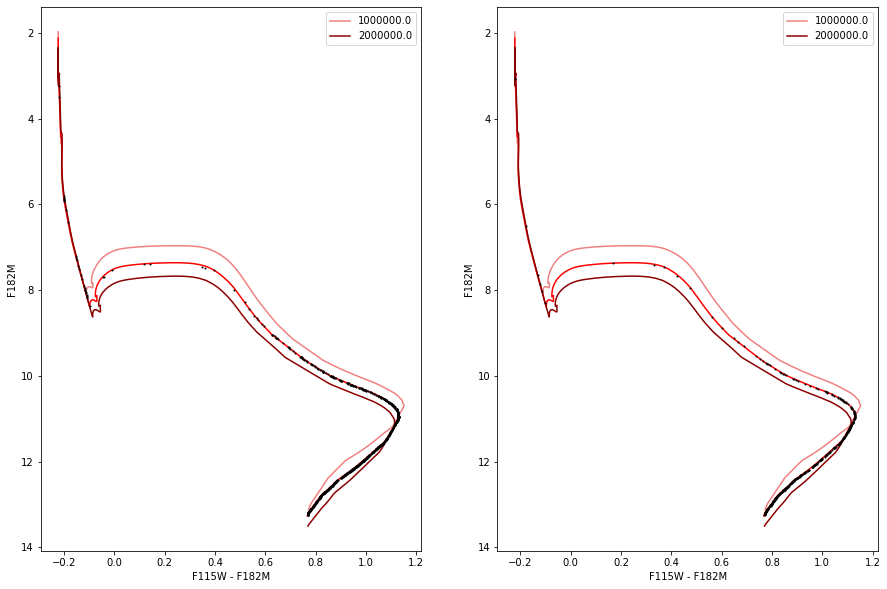

In [11]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [12]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.9e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

for i in range(len(unresolved_binaries)):
    print(unresolved_binaries[i])

[12.190921021787362, 11.184608530964091]
None
None
[11.830747405966179, 10.76979314053871]
None
None
None
[12.98000225508591, 12.182187543830565]
[10.389981441622528, 9.487822696021052]
[11.950337988254722, 10.908352862148432]
None
[12.656130989842788, 11.795507120620472]
None
[12.353456507203047, 11.394724120542943]
[11.949517138373523, 10.90659618538517]
None
None
None
None
None
[10.810210078286964, 9.803760646216169]
None
None
[12.007514571855635, 10.974050516952849]
None
[12.266359500487221, 11.294688777705106]
[12.676920416631667, 11.8209727624234]
None
None
[10.084820973533661, 9.27676465727519]
None
None
[12.468767593582207, 11.542366646124599]
None
None
None
None
None
[12.806464279450715, 11.972289278509793]
[13.006542403244206, 12.214572315047645]
[10.83077401540059, 9.775553456581012]
[11.497774015400587, 10.390555254432691]
None
None
[10.884630616592247, 9.813180248587996]
[11.304605037338478, 10.184424550323094]
None
None
None
None
None
None
[11.165216403309582, 10.06289888

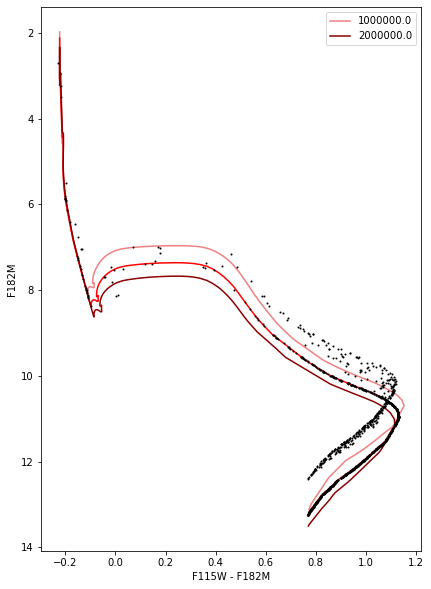

In [13]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='k')